In [1]:
pip install nba_api

Note: you may need to restart the kernel to use updated packages.


[documentation Github](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md)

## Importation

In [2]:
# DATA
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore
# NBA API
pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# VISUALISATION DU COURS
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

D:\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Création du terrain de basket

J'ai utilisé [ce site](https://ichi.pro/fr/creation-du-shotchart-nba-a-l-aide-de-python-101538722011397) pour dessiner le terrain de basket

In [3]:
def draw_court(ax=None, color="white", lw=1, shotzone=False, outer_lines=False):
    if ax is None:
        ax = plt.gca()
    
    # Création des différentes parties d'un terrain de basketball de la NBA
    
    # Création du panier de basketball
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    
    # Création du panneau arrière
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)
    
    # La zone peinte
    # Création de la zone extérieure de la peinture, largeur=16 pieds, hauteur=19 pieds
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    # Création de la zone intérieure de la peinture, largeur=12 pieds, hauteur=19 pieds
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
    
    # Création de l'arc supérieur de lancers francs
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    # Création de l'arc inférieur de lancers francs
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    # Zone restreinte, c'est un arc avec un rayon de 4 pieds depuis le centre du panier
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)
    
    # Ligne à trois points
    # Création des lignes à trois points du côté droit, longueur de 14 pieds avant l'arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    # Création des lignes à trois points du côté gauche, longueur de 14 pieds avant l'arc
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # Arc à trois points - le centre de l'arc est le panier, l'arc est à 23'9" du panier
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
    
    # Centre du terrain
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)
    
    # Dessiner les lignes de la zone de tir
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x = Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrés
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrés
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # On suppose que la distance x est aussi de 40 pour le point final
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # On suppose que la distance y est aussi de 92.5 pour le point final
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        # Liste des éléments du terrain à tracer sur l'axe
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc, center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x, inner_line_1, inner_line_2, inner_line_3, inner_line_4,
                          inner_line_5, inner_line_6]
    else:
        # Liste des éléments du terrain à tracer sur l'axe
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, restricted,
                          corner_three_a, corner_three_b, three_arc, center_outer_arc, center_inner_arc]
    
    if outer_lines:
        # Trace la ligne de milieu de terrain, la ligne de fond et les lignes de côté
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)
    
    # Ajoute les éléments du terrain sur l'axe
    for element in court_elements:
        ax.add_patch(element)
    
    return ax

## Création des fonctions

Nous allons créer une fonction qui nous permettrons d'identifier un joueur ainsi qu'une saison spécifique grâce à son ID de joueur et d'équipe afin de récupérer les détails des tirs en utilisant l'API NBA.

In [4]:
def get_player_shotchartdetail(player_name, season_id):
   
    # Récupération de la liste des joueurs de la NBA
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # Obtention des statistiques du joueurs et conversion en Dataframe
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # Récupération de l'ID de l'équipe sur la saison choisie
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # Récupération des détails des tirs du joueur
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

Création d'une fonction qui afficher les tirs réussis et ratés d'un joueur sur le terrain.

In [5]:
def shot_chart(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()
    # Si aucun axe n'est fourni, utilise l'axe par default de Matplotlib

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])
    # Fixe les limites de l'axe pour représenter le terrain de basket

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)
    # Définit le titre du graphique

    # Dessine le terrain de basket
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    # Sépare les couleurs par tir réussi ou raté
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']

    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']

    # Trace les tirs ratés
    ax.scatter(x_missed, y_missed, c='r', marker="x", s=300, linewidths=3, **kwargs)
    # Trace les tirs réussis
    ax.scatter(x_made, y_made, facecolors='none', edgecolors='g', marker="o", s=100, linewidths=3, **kwargs)

    return ax

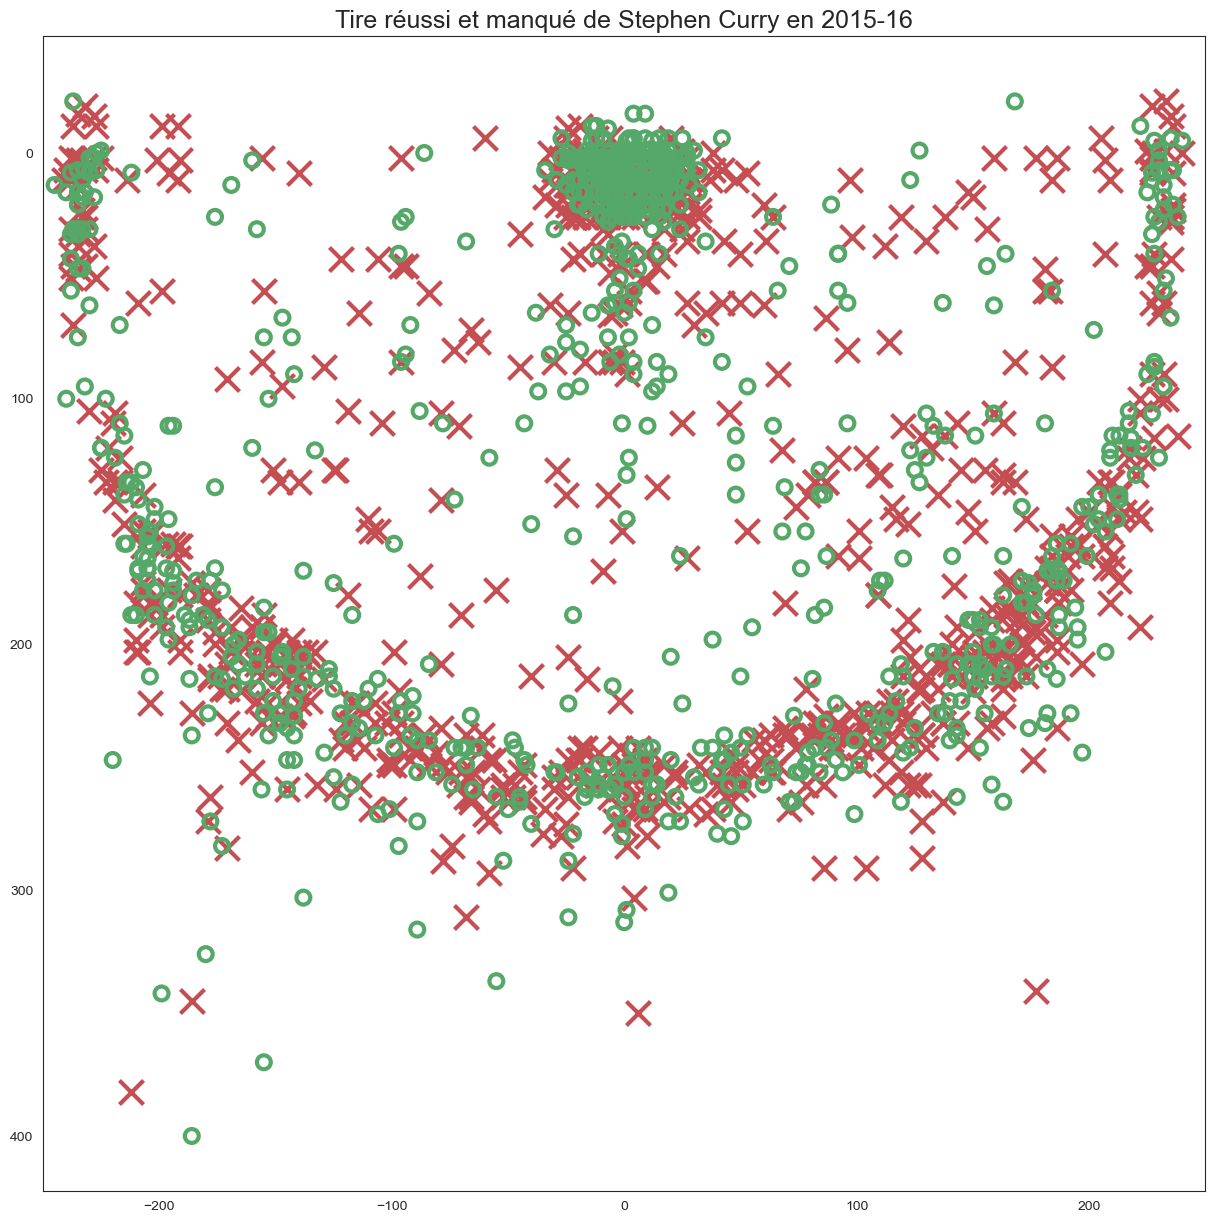

In [6]:
# Choix du joueur et de la saison
player_name = "Stephen Curry"
season_id = "2015-16"
player_shotchart_df, league_avg = get_player_shotchartdetail(player_name, season_id)

# Création de la figure et utilisation de la fonction
fig, ax = plt.subplots(figsize=(15, 15))
shot_chart(player_shotchart_df, title="Tire réussi et manqué de Stephen Curry en 2015-16", ax=ax)


plt.show()

### Amélioration du visuel

Création d'une fonction pour redimensionner les hexagones dans un graphique.

En basant sur les valeurs des données pour les ajuster selon différentes conditions.

In [7]:
def sized_hexbin(ax, hc, hc2, cmap, norm):
    # Récupération des positions
    offsets = hc.get_offsets()
    orgpath = hc.get_paths()[0]
    verts = orgpath.vertices
    values1 = hc.get_array()
    values2 = hc2.get_array()
    
    # Calcul de la valeur maximale des hexbins
    ma = values1.max()
    
    patches = []

    # Ajustement de leurs tailles en fonction des valeurs
    for offset, val in zip(offsets, values1):
        # Suppression des valeurs 0 pour comparer la fréquence sans les 0
        filtered_list = list(filter(lambda num: num != 0, values1))
        
        # On saute également les comptes de fréquence qui sont des 0
        # Cela permet de ne pas considérer les hexbins sans occurrence de données
        if int(val) == 0:
            continue
        elif percentileofscore(filtered_list, val) < 33.33:
            v1 = verts * 0.3 + offset  # Redimensionnement pour les valeurs inférieures
        elif percentileofscore(filtered_list, val) > 69.99:
            v1 = verts + offset  # Redimensionnement pour les valeurs supérieures
        else:
            v1 = verts * 0.6 + offset  # Redimensionnement pour les valeurs intermédiaires
        
        # Création du nouveau chemin avec la taille ajustée
        path = Path(v1, orgpath.codes)
        patch = PathPatch(path)
        patches.append(patch)

    # Création de la collection de patchs pour les hexbins redimensionnés
    pc = PatchCollection(patches, cmap=cmap, norm=norm)
    pc.set_array(values2)  # Définition de la couleur en fonction des valeurs
    
    # Ajout de la collection à l'axe et suppression des anciens hexbins
    ax.add_collection(pc)
    hc.remove()
    hc2.remove()

    return ax

Création d'une fonction qui prend les données de tir du joueur choisi.

Calcule la différence de réussite par zone de tir par rapport à la moyenne de la ligue, et crée une représentation visuelle 

In [8]:
def hexmap_chart(data, league_avg, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="#1a477b", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):
    
    # Calcul des statistiques de tir pour le joueur par zone de tir
    LA = league_avg.loc[:,['SHOT_ZONE_AREA','SHOT_ZONE_RANGE', 'FGA', 'FGM']].groupby(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    player = data.groupby(['SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)
    player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100  

    data = pd.merge(data, player_vs_league, on=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], how='right')
    
    # Configuration de l'axe et du terrain de basketball
    if ax is None:
        ax = plt.gca()
        ax.set_facecolor(court_color)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # Dessine le terrain 
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    x = data['LOC_X']
    y = data['LOC_Y']
        
    colors = ['#2b7cb6', '#abd9e9', '#ffffbf', '#fdaf61', '#d7191c', '#a50026']
    cmap = ListedColormap(colors)

    # Définit les limites de couleurs pour les hexbins
    boundaries = [-np.inf, -9, -3, 0, 3, 9, np.inf]
    norm = BoundaryNorm(boundaries, len(colors))
    
    # Premier hexbin requis pour le décompte
    # Deuxième hexbin pour la coloration de chaque hexagone
    hexbin = ax.hexbin(x, y, gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    hexbin2 = ax.hexbin(x, y, C=data['FGP'], gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    # Fonction pour redimensionner les hexbins en fonction de leur fréquence
    sized_hexbin(ax, hexbin, hexbin2, cmap, norm) 
    
    # Configure les bordures pour correspondre aux lignes du terrain
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

**Visualisation de certain MVP dans l'histoire de la NBA**

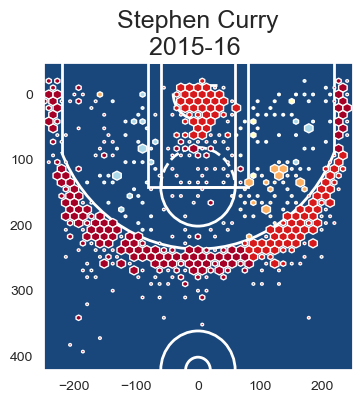

In [9]:
# Choix du joueur et de la saison
player_name = "Stephen Curry"
season_id = "2015-16"
player_shotchart_df, league_avg = get_player_shotchartdetail(player_name, season_id)

# Création de la figure et utilisation de la fonction
fig, ax = plt.subplots(figsize=(4, 4))
hexmap_chart(player_shotchart_df, league_avg, title="Stephen Curry\n2015-16 ", ncolors=6)


plt.show()

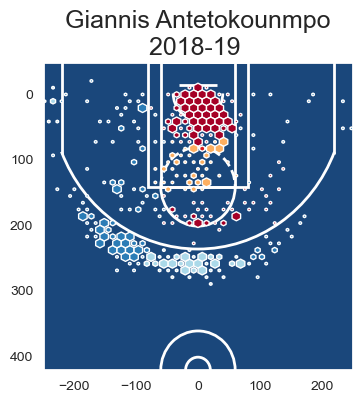

In [13]:
player_name = "Giannis Antetokounmpo"
season_id = "2018-19"
player_shotchart_df, league_avg = get_player_shotchartdetail(player_name, season_id)

fig, ax = plt.subplots(figsize=(4, 4))
hexmap_chart(player_shotchart_df, league_avg, title="Giannis Antetokounmpo\n2018-19 ", ncolors=6)


plt.show()

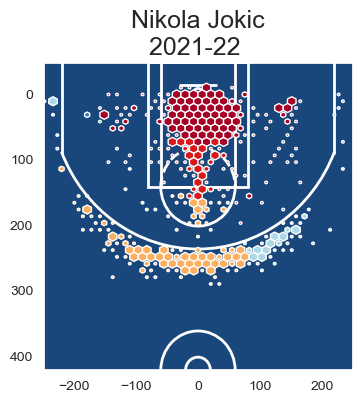

In [12]:
player_name = "Nikola Jokic"
season_id = "2021-22"
player_shotchart_df, league_avg = get_player_shotchartdetail(player_name, season_id)

fig, ax = plt.subplots(figsize=(4, 4))
hexmap_chart(player_shotchart_df, league_avg, title="Nikola Jokic\n2021-22 ", ncolors=6)


plt.show()